# Ovrlpy applied to vizgen receptor data map



#### Imports:

In [1]:
%load_ext autoreload
%autoreload 2

#### Parameter definition:

In [2]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata
import time

perf = time.perf_counter()
perf_ = perf

print(time.perf_counter()-perf)


0.00012749619781970978


In [3]:
n_slice = 2

coordinate_path = f'/dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-receptor-showcase/Slice{n_slice}/Replicate1/detected_transcripts_S{n_slice}R1.csv'
# analysis/tiesmeys/data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/detected_transcripts_S1R1.csv'

scale=1 # scaling factor for images/coordinats. We want to end up with cell diameter ~30px (cellpose default)
# model_type='cyto2' # cellpose model name. ['dapi','cyto','cyto2']

In [4]:
# SSAM vector field resolution:

kde_bandwidth = 1
um_per_pixel = 1.5
min_expression = 1.5

# SSAM pandwidth:

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


           global_x      global_y      global_z
count  4.874067e+07  4.874067e+07  4.874067e+07
mean   4.974135e+03  3.696136e+03  2.847259e+00
std    2.237596e+03  1.731014e+03  1.945633e+00
min    5.302726e+01 -7.666222e+01  0.000000e+00
25%    3.236294e+03  2.256036e+03  1.000000e+00
50%    4.957519e+03  3.637856e+03  3.000000e+00
75%    6.799679e+03  5.120410e+03  4.000000e+00
max    9.692914e+03  7.453246e+03  6.000000e+00


<AxesSubplot: xlabel='x', ylabel='y'>

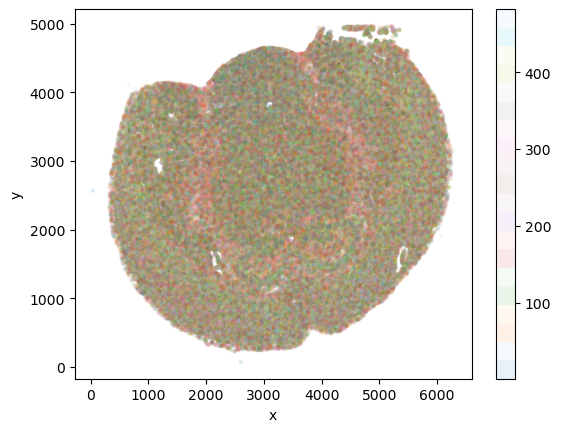

In [5]:
# Load coordinate_path data frame, read only the columns
# global_x, global_y, global_z, fov	gene:

import time

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[::1]

print(df.describe())


df.columns=['x','y','z','gene']
df = df[~df.gene.str.contains('Blank')]
# df.x-=df.x.min()
# df.y-=df.y.min()
df.x/=um_per_pixel/scale
df.y/=um_per_pixel/scale
df.z/=um_per_pixel/scale

# df.gene.replace({'Acte1':'Gm498'})

df.gene = df.gene.astype('category')
gene_counts = df.gene.value_counts()
genes = list(gene_counts.index)

df[::200].plot.scatter(x='x',y='y',s=5,c=df[::200].gene.cat.codes,cmap='tab20',alpha=0.1)



In [6]:
# pd.to_parquet(f"./publication/vizgen-receptor/coordinates-Slice{n_slice}.parquet", df)

In [7]:
signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(np.mean).T

signatures = pd.DataFrame(index=genes,columns=signatures_.columns)
signatures = signatures.fillna(0)

for gene in genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 
signatures.columns=signatures.columns.str.replace('/','-')


/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


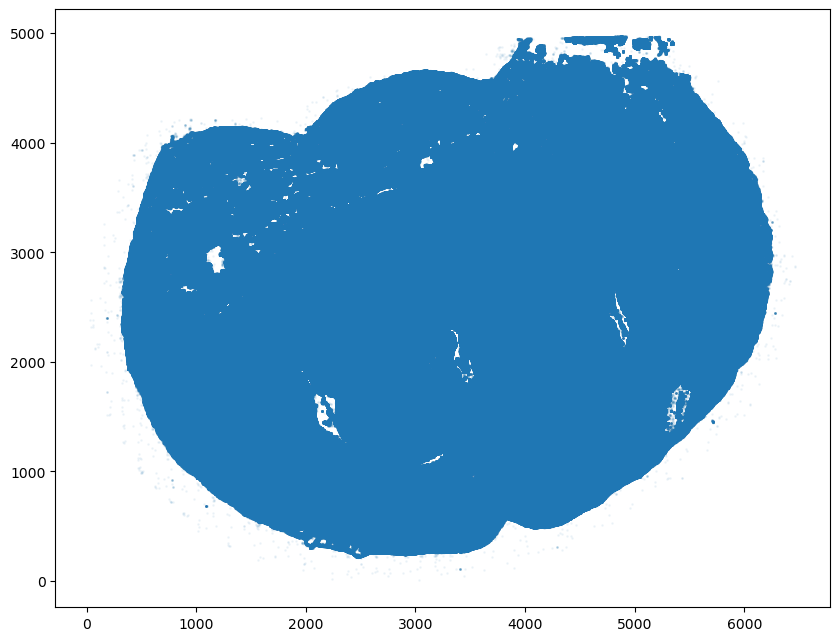

In [8]:
#
plt.figure(figsize=(10,10))


x_lims = [0,10000]
y_lims = [0,10000]

df_mask = (df.x>x_lims[0]) & (df.x<x_lims[1]) & (df.y>y_lims[0]) & (df.y<y_lims[1])

df = df[df_mask].copy()

mins = df[['x','y']].min()

# df.x-=df.x.min()
# df.y-=df.y.min()

plt.scatter(df.x,df.y,s=1,alpha=0.05)
plt.gca().set_aspect('equal') 
df.gene = df.gene.astype('str').astype('category')
gene_counts = df.gene.value_counts()
genes = gene_counts.index

# Adhere to project's global naming convention:
coordinate_df = df.copy()
del df


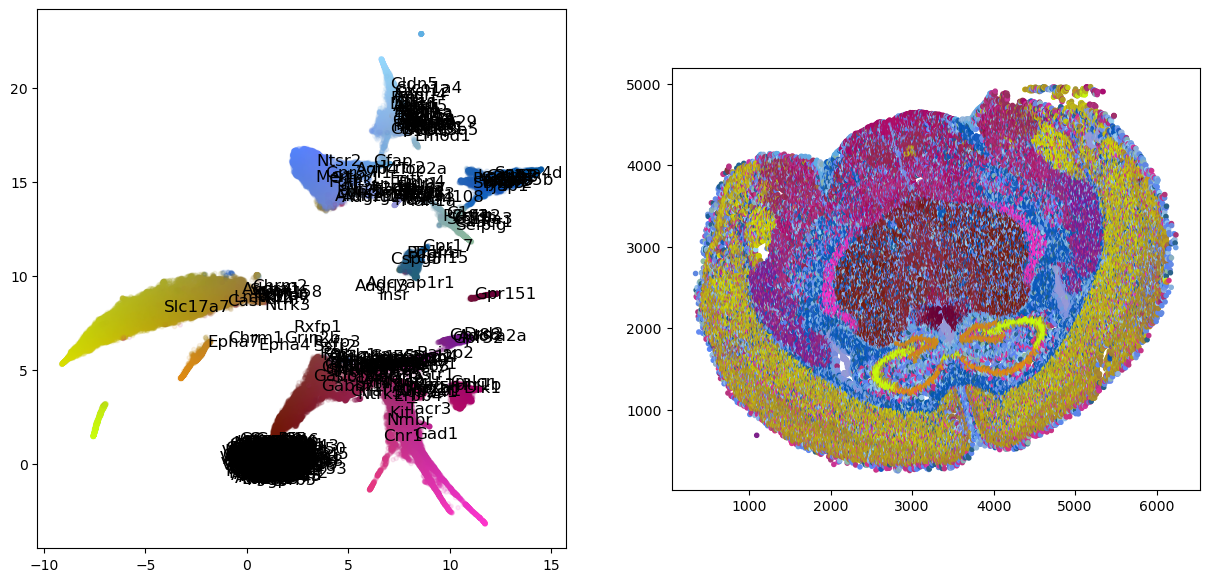

In [9]:

from src import ovrlp 
import random

random.seed(1000)

ovrlp.assign_xy(coordinate_df)
ovrlp.assign_z_mean(coordinate_df)

# visualizer = ovrlp.Visualizer(KDE_bandwidth=1,
#                 celltyping_min_expression=min_expression,
#                 celltyping_min_distance=7,
#                 n_components_pca=20,)

# visualizer.fit_ssam(coordinate_df, signature_matrix=None)

# visualizer.save(f"./publication/vizgen-receptor/visualizer-s{n_slice}.viz")

visualizer = ovrlp.load_visualizer(f"./publication/vizgen-receptor/visualizer-s{n_slice}.viz")

visualizer.plot_fit()


In [10]:
coherence_, signal_ = ovrlp.compute_divergence_patched(coordinate_df, visualizer.genes, visualizer.pca_2d.components_,
KDE_bandwidth=1.5, min_expression=1.5,n_workers=2)

[   0 1077 2154 3231 4308 5385 6462] [   0 1242 2484 3726 4969]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 19/24 [08:24<02:33, 30.71s/it]/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy/src/utils.py:504: RuntimeWarning: invalid value encountered in true_divide
  patch_cosine_similarity = np.sum(patch_embedding_top*patch_embedding_bottom,axis=1)/(patch_norm_top*patch_norm_bottom)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [09:55<00:00, 24.80s/it]


/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


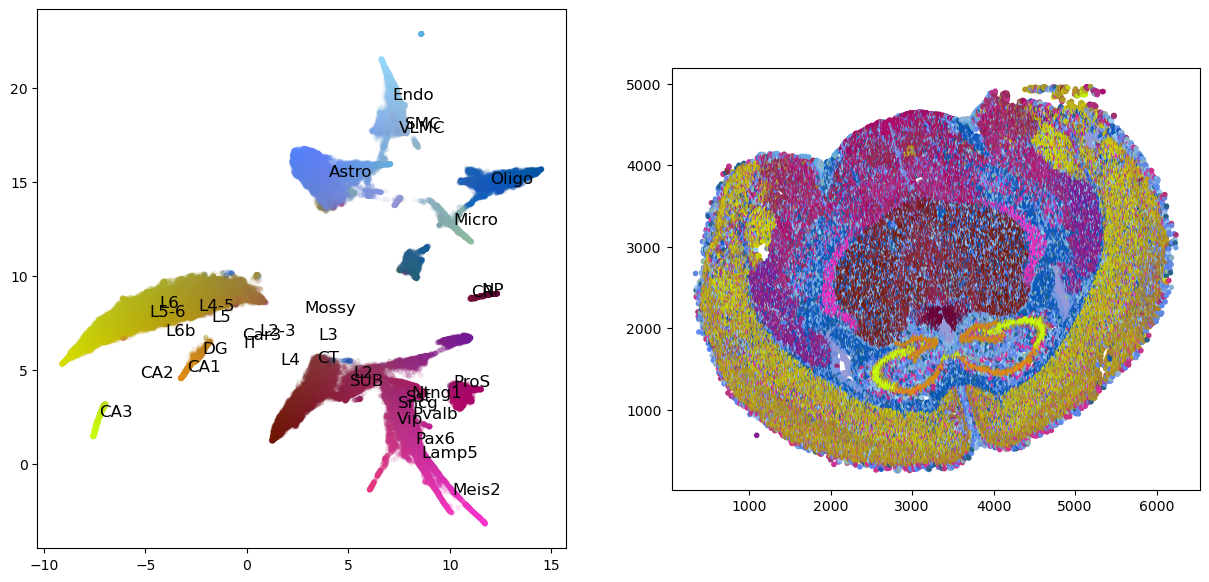

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')

signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(np.mean).T

signatures = pd.DataFrame(index=visualizer.genes,columns=signatures_.columns)
signatures = signatures.fillna(0)

for gene in visualizer.genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 

signatures.columns=signatures.columns.str.replace('/','-')

visualizer.fit_signatures(signatures)

visualizer.plot_fit()

([<matplotlib.lines.Line2D at 0x1479832b43a0>], Text(350.0, 200, '1mm'))

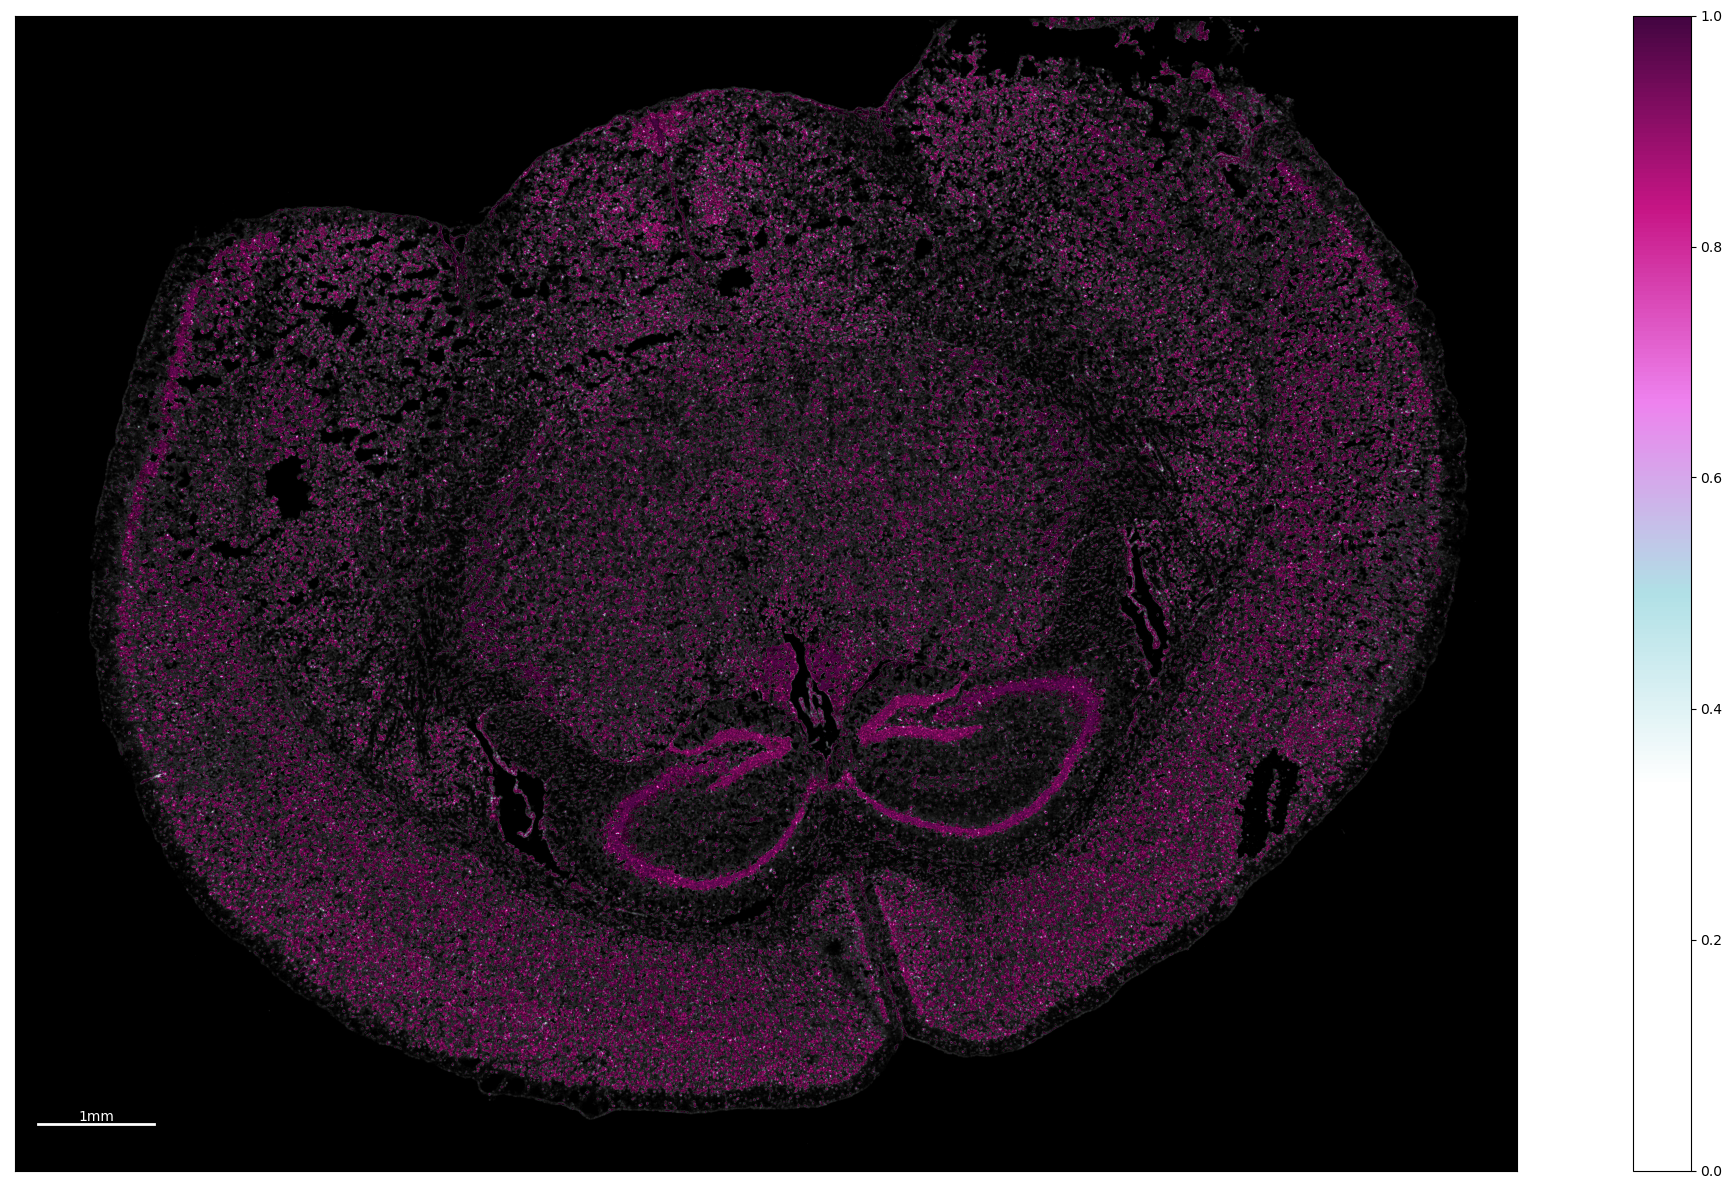

In [12]:
from src.utils import plot_scalebar
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('', ['#430541','mediumvioletred','violet','powderblue','white','white','white'][::-1])

plt.figure(figsize=(30,15))
ax = plt.subplot(111,facecolor='k')
plt.imshow(coherence_.T,alpha=signal_.T.clip(0,10)/10,cmap=cmap,vmin=0,vmax=1)
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])

plt.colorbar()
plot_scalebar(ax,100,200,500,text='1mm',color='w',edge_color=None)


